# Exploring the MCTS

In [43]:
import numpy as np
import torch
from muzero_model.utils import load_saved_model, load_saved_model_only
from muzero_model.models import Nets, Alphazero_wrapper
from muzero_model.breakthrough import State, Board
from muzero_model.mcts import Tree
import os

from utils import get_image_array
import matplotlib.pyplot as plt

BASE_PATH = "/home/ap/Documents/phd/muzero/game/muzero_model/model_checkpoints/alpha_v04/models"
MODEL_PATH = "alpha_v04_model_0000000000_ep_20210531_115302.pkl"
NUM_FILTERS = 64
NUM_BLOCKS = 5

nets = Alphazero_wrapper(num_blocks = NUM_BLOCKS, num_filters = NUM_FILTERS)
model = load_saved_model_only(os.path.join(BASE_PATH,MODEL_PATH), nets)

In [102]:
grid = np.array([[0, 2, 0, 2, 0],
                [2, 0, 2, 2, 2],
                [1, 0, 1, 0, 1],
                [0, 1, 0, 1, 0],
                [0, 1, 1, 1, 0],
                [1, 1, 1, 1, 1]])
player_to_move = 1

board = Board(5, grid)
state = State(board=board, player_to_move = player_to_move)

In [103]:
tree = Tree(model)   

p_target = tree.think(state, 400, 0.1, show=True)

6  . B . B .
5  B . B B B
4  W . W . W
3  . W . W .
2  . W W W .
1  W W W W W

   a b c d e



In [104]:
import copy

def rollout(state, path):
    state_ = copy.deepcopy(state)
    if len(path) > 0:
        actions = path.split('|')[1].split(' ')    
        for action in actions:
            state_.play(int(action))        
    return state_

In [105]:
state_2 = rollout(state, list(tree.nodes.keys())[50])
print(state.board.num_grid)
print(state_2.board.num_grid)

[[  0 201   0 202   0]
 [203   0 204 205 206]
 [107   0 108   0 109]
 [  0 110   0 111   0]
 [  0 112 113 114   0]
 [115 116 117 118 119]]
[[  0 201   0 202   0]
 [  0   0 204 108 206]
 [107 203   0   0 109]
 [  0 110   0 111   0]
 [  0 112 113 114   0]
 [115 116 117 118 119]]


In [106]:
from captum.attr import IntegratedGradients
from torch import nn

class single_output_forward_class(nn.Module):
    def __init__(self,
                model,
                out_ind):
        super(single_output_forward_class, self).__init__()
        self.model = model
        self.out_ind = out_ind
        
    def forward(self, x):
        yhat = self.model.prediction(x)
        return yhat[self.out_ind]

single_output_model = single_output_forward_class(model, 1)

def get_integrated_gradients(state):

    input = state.feature()
    baseline = np.ones_like(input)/2
    input = torch.from_numpy(input).unsqueeze(0).float()
    baseline = torch.from_numpy(baseline).unsqueeze(0).float()

    ig = IntegratedGradients(single_output_model)
    attributions, delta = ig.attribute(input, baseline*0, target=0, return_convergence_delta=True)
    mat = attributions.detach().numpy().squeeze(0)
    return mat

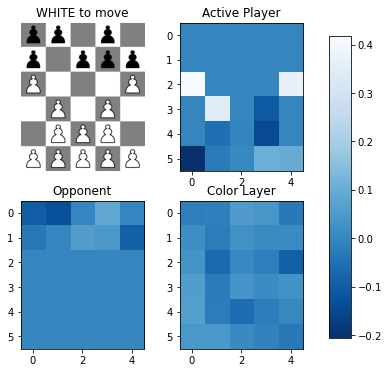

In [95]:
mat = get_integrated_gradients(state)
show_mat(mat, state)

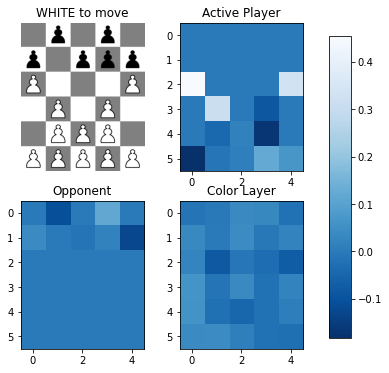

In [101]:
mat = get_integrated_gradients(state)
show_mat(mat, state)

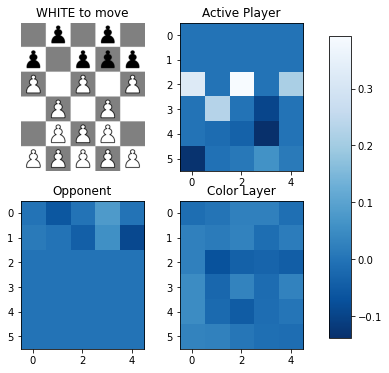

In [107]:
mat = get_integrated_gradients(state)
show_mat(mat, state)

In [108]:
ig_mat = []
states = []
for path in tree.nodes.keys():
    
    state_ = rollout(state, path)
    mat = get_integrated_gradients(state_)
    if state_.player_to_move == 1:
        #show_mat(mat, state_)
        ig_mat.append(mat)
        states.append(state_)

In [109]:
from collections import defaultdict
original_state = copy.deepcopy(state)
p_pos = np.where(original_state.board.num_grid != 0)

imp_dict = defaultdict()

for idx, (x,y) in enumerate(zip(p_pos[0],p_pos[1])):
    val = original_state.board.num_grid[x][y]
    imp_dict[val] = []
    

def get_imp(mat, x, y, val):
    if str(val)[0] == '1':
        imp_ = mat[0,x,y]
        imp_dict[val].append(imp_)
    else:
        imp_ = mat[1,x,y]
        imp_dict[val].append(imp_)
    
        
        

for mat_, state_ in zip(ig_mat, states):
    p_pos = np.where(state_.board.num_grid != 0)
    for idx, (x,y) in enumerate(zip(p_pos[0],p_pos[1])):
        val = state_.board.num_grid[x][y]
        get_imp(mat_, x, y, val)
    

In [110]:
import pandas as pd
df = pd.DataFrame.from_dict(imp_dict, orient='index')
df = df.T
df.mean(axis = 0).sort_values()

115   -0.162729
114   -0.113365
201   -0.094427
206   -0.078049
204   -0.070712
205   -0.033647
111   -0.032814
116   -0.013095
113   -0.009864
112   -0.003348
203    0.012332
117    0.032788
119    0.048974
202    0.071859
118    0.074406
109    0.228703
110    0.278115
107    0.313567
108    0.347299
dtype: float64

In [113]:
print(state.board.num_grid)

[[  0 201   0 202   0]
 [203   0 204 205 206]
 [107   0 108   0 109]
 [  0 110   0 111   0]
 [  0 112 113 114   0]
 [115 116 117 118 119]]


array([[ 0.        , -0.09442719,  0.        ,  0.07185897,  0.        ],
       [ 0.0123324 ,  0.        , -0.07071222, -0.03364651, -0.07804942],
       [ 0.31356708,  0.        ,  0.34729869,  0.        ,  0.22870254],
       [ 0.        ,  0.27811464,  0.        , -0.03281385,  0.        ],
       [ 0.        , -0.00334815, -0.00986395, -0.11336539,  0.        ],
       [-0.16272903, -0.0130952 ,  0.03278808,  0.07440586,  0.04897376]])

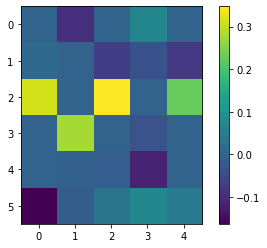

In [112]:
imp = np.zeros_like(state.board.num_grid, dtype = float)

for i, row in enumerate(state.board.num_grid):
    for j, item in enumerate(row):
        vals = imp_dict.get(item,0)
        val = np.mean(vals)
        imp[i,j] = val
plt.imshow(imp)
plt.colorbar()
imp

In [73]:
def show_mat(mat, state, title = None, show_title = True, save = False):
    img = get_image_array(state)
    
    cmap = 'Blues_r'
    
    fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, figsize = (6,6))
    if title:
        if show_title:
            fig.suptitle(title, fontsize=15)
    vmin = mat.min()
    vmax = mat.max()
    ax0.imshow(img)
    ax0.axis('off')
    player = 'WHITE' if state.player_to_move == 1 else 'BLACK'
    ax0.set_title(player + ' to move')
    
    im = ax1.imshow(mat[0], vmin=vmin, vmax=vmax, cmap = cmap)
    ax1.set_title('Active Player')
    im = ax2.imshow(mat[1], vmin=vmin, vmax=vmax, cmap = cmap)
    ax2.set_title('Opponent')
    im = ax3.imshow(mat[2], vmin=vmin, vmax=vmax, cmap = cmap)
    ax3.set_title('Color Layer')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    if save:
        plt.savefig(title+'.png')
    plt.show()

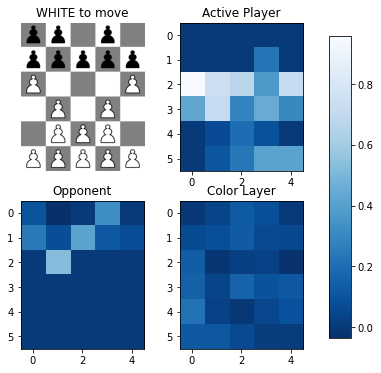

In [58]:
mat = np.max(ig_mat, axis = 0)
show_mat(mat, state)

In [59]:
grid = np.array([[2, 2, 0, 2, 0],
                [2, 2, 2, 2, 2],
                [1, 0, 0, 0, 1],
                [0, 1, 0, 1, 0],
                [0, 1, 1, 1, 0],
                [1, 1, 1, 1, 1]])

In [67]:
m[1]

array([0, 1, 3, 0, 1, 2, 3, 4, 0, 4, 1, 3, 1, 2, 3, 0, 1, 2, 3, 4])

In [65]:
zip(m[0][0],m[1][0])

TypeError: 'numpy.int64' object is not iterable

In [80]:
m = np.where(grid!=0)
em = np.zeros_like(grid)
for idx, (x,y) in enumerate(zip(m[0],m[1])):
    num = idx + 1
    em[x,y] = num
    print(num,x,y)
print(em)

1 0 0
2 0 1
3 0 3
4 1 0
5 1 1
6 1 2
7 1 3
8 1 4
9 2 0
10 2 4
11 3 1
12 3 3
13 4 1
14 4 2
15 4 3
16 5 0
17 5 1
18 5 2
19 5 3
20 5 4
[[ 1  2  0  3  0]
 [ 4  5  6  7  8]
 [ 9  0  0  0 10]
 [ 0 11  0 12  0]
 [ 0 13 14 15  0]
 [16 17 18 19 20]]
